In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#for neural network
import tensorflow as tf
from tensorflow import keras
from keras import layers, models
from keras.models import Sequential, Model, load_model
from keras.layers import Reshape, Dense, Input
from sklearn.model_selection import train_test_split
import keras_tuner as kt

import sys
np.set_printoptions(threshold=sys.maxsize)


# data


In [6]:
df=pd.read_csv('/Users/vedantgupta/Documents/summer project/data-analysis-with-technical-indicators-1/nifty_sensex_close_data/data/M&M.NS_2011_to_2023.csv')


In [78]:

def make_dataset(df,w):
    
    l=int(len(df))
    n=int(0.8*(l-w))

    #for close price
    df_close=df['M&M.NS_close']
    df_close = df_close.astype(float)
    data_i=np.zeros((l-w,w))

    for i in range (l-w):
        for j in range(w):
            data_i[i][j]=df_close[i+j]

    data_o=np.array([df_close[i+w] for i in range(l-w)])
    data_o=data_o.reshape(l-w,1)

    data=np.column_stack((data_i,data_o))

    #training and validating data
    tv_data=data[:n,:]
    np.random.seed(0)
    np.random.shuffle(tv_data)

    #test data
    test_data=data[n:,:-1]
    act_data=data[n:,-1]
    
    return tv_data,test_data,act_data

In [79]:
#splitting the dataset into training and valdation

def split_dataset(ran_tv_close):
    
    X_close=ran_tv_close[:,:-1]
    y_close=ran_tv_close[:,-1]
    X_train_close, X_val_close, y_train_close, y_val_close = train_test_split(X_close, y_close, test_size=0.2, random_state=0)

    return X_train_close, X_val_close, y_train_close, y_val_close


In [92]:
tv_data,test_data,act_data=make_dataset(df,25)
X_train_close, X_val_close, y_train_close, y_val_close=split_dataset(tv_data)

X_train_close.shape, X_val_close.shape, y_train_close.shape, y_val_close.shape, test_data.shape, act_data.shape

((2034, 25), (509, 25), (2034,), (509,), (636, 25), (636,))

# model


In [69]:
initalizer2 = keras.initializers.HeNormal

tf.keras.backend.clear_session()

In [93]:
w=25
def model_builder(hp):
  model = keras.Sequential()
  act = hp.Choice('activation', values=['relu','sigmoid', 'tanh'])
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  hl = hp.Int('layers', min_value=2, max_value=6, step=1)
  model.add(Dense(hp_units, input_shape=(w,), activation=act, name = 'Input'))
  for i in range(hl):
    model.add(Dense(units=hp_units, activation=act))
  model.add(Dense(1))
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate), loss='mse',metrics=['mape'] )
  return model

In [94]:
tuner = kt.Hyperband(model_builder, objective=kt.Objective("val_mape", direction="min"), max_epochs=10, factor=3, directory='/Users/vedantgupta/Downloads/ki', project_name='intro_to_kt')


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [95]:
tuner.search(X_train_close,y_train_close, epochs=100, batch_size=25, validation_data=(X_val_close,y_val_close))
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
model=tuner.hypermodel.build(best_hps)
print(model.summary())

history=model.fit(X_train_close, y_train_close, epochs=100, batch_size=25, validation_data=(X_val_close,y_val_close))


Trial 30 Complete [00h 00m 12s]
val_mape: 1.9205466508865356

Best val_mape So Far: 1.847165584564209
Total elapsed time: 00h 04m 20s


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (Dense)                   │ (None, 512)            │        13,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,589,761 (6.06 MB)

 Trainable params: 1,589,761 (6.06 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 67786.0312 - mape: 33.9422 - val_loss: 940.7373 - val_mape: 4.3037
Epoch 2/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 821.5582 - mape: 3.9122 - val_loss: 606.6870 - val_mape: 3.4478
Epoch 3/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 401.6213 - mape: 2.7800 - val_loss: 249.4779 - val_mape: 2.1904
Epoch 4/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 266.5826 - mape: 2.2585 - val_loss: 245.3369 - val_mape: 2.1992
Epoch 5/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 256.0167 - mape: 2.2295 - val_loss: 246.7861 - val_mape: 2.2289
Epoch 6/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 244.2985 - mape: 2.0903 - val_loss: 162.6426 - val_mape: 1.7718
Epoch 7/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 203.2266 - mape: 1.9820 - val_loss: 444.6826 - val_mape: 3.3395
Epoch 8/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 280.6791 - mape: 2.3244 - val_loss: 362.5107 - val_mape: 2.8687


In [96]:
test_pred=model.predict(test_data)

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [97]:


#mae and accuracy for test data
def mae_accuracy_test(y_pred_close,act_data):

    mae_close = np.mean(abs(y_pred_close - act_data))

    return mae_close

In [107]:
act_data=act_data.reshape(len(act_data),1)

mae=mae_accuracy_test(test_pred,act_data)
print('mae_test=',mae)

#r2 score for test data
from sklearn.metrics import r2_score
r2=r2_score(act_data,test_pred)
print('r2_test=',r2)

#mape for test data
mape_=np.mean(np.abs((act_data - test_pred) / act_data)) * 100
print('mape_test=',mape_)

#accuracy for test data
acc_test=1-(mae/np.mean(act_data))
print("Accuracy for test data is: ",acc_test)


mae_test= 14.612476180934307
r2_test= 0.9954382936176549
mape_test= 1.32093698531843
Accuracy for test data is:  0.9871477321957608


# plotting


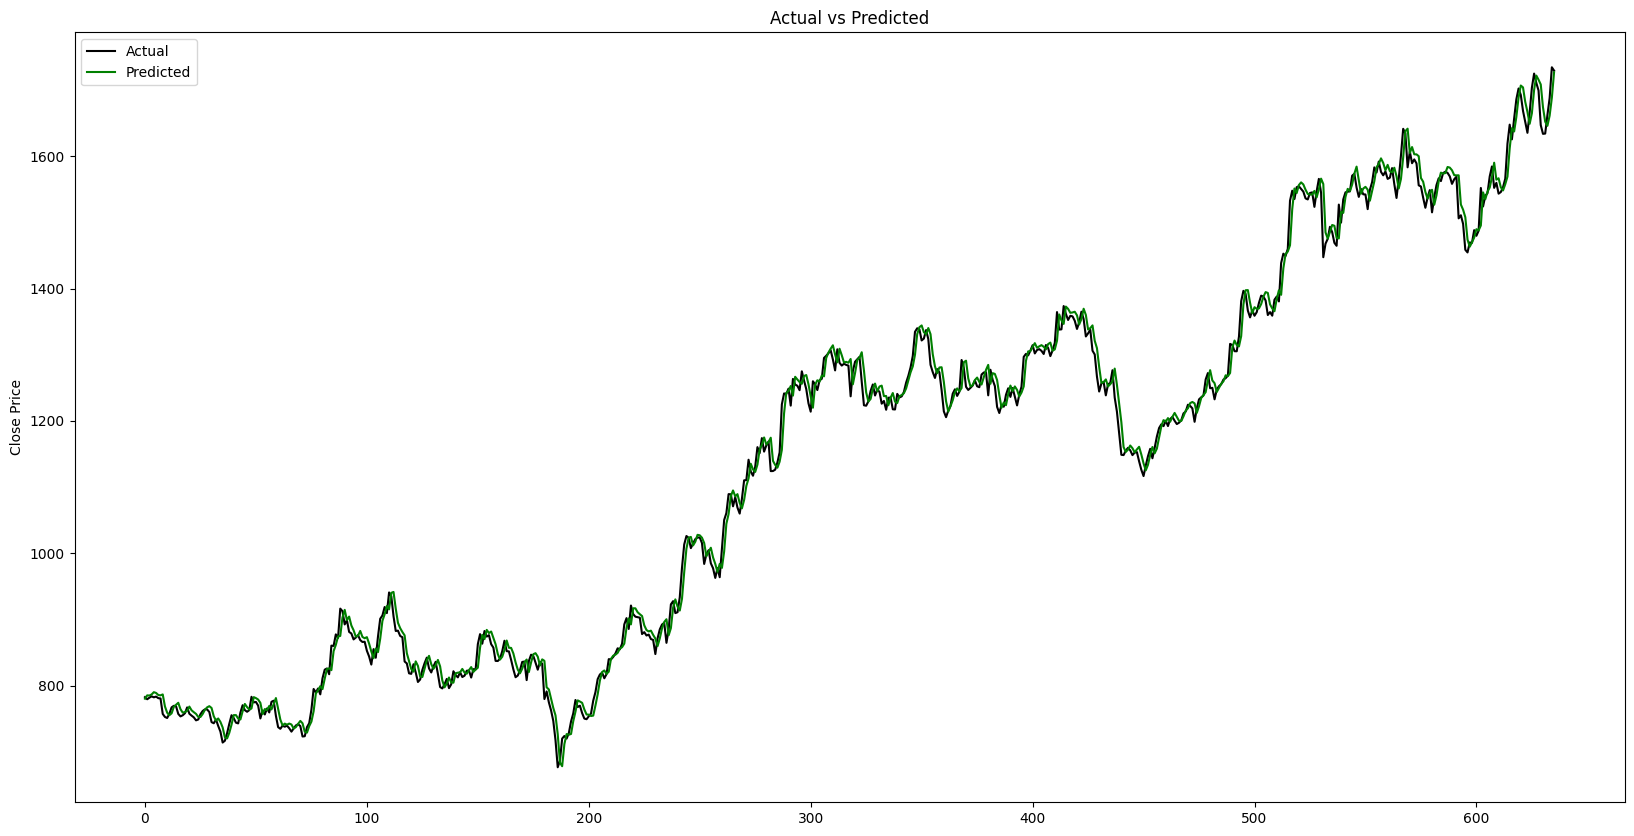

In [108]:
#plot actual vs predicted for test data

plt.figure(figsize=(20,10))
plt.plot(act_data, color = 'black', label = 'Actual')
plt.plot(test_pred, color = 'green', label = 'Predicted')
plt.title('Actual vs Predicted')
plt.ylabel('Close Price')
plt.legend()
plt.show()

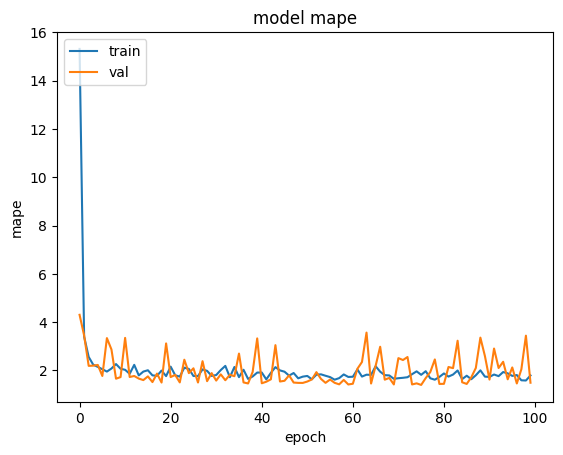

In [109]:
#plot epochs vs mape
plt.plot(history.history['mape'], label='mape')
plt.plot(history.history['val_mape'], label='val_mape')
plt.title('model mape')
plt.ylabel('mape')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()



In [111]:
act_data

array([[ 782.56634521],
       [ 779.27276611],
       [ 781.69451904],
       [ 783.68035889],
       [ 782.17883301],
       [ 783.29284668],
       [ 780.9196167 ],
       [ 780.48364258],
       [ 757.08947754],
       [ 752.53656006],
       [ 750.93823242],
       [ 757.47698975],
       [ 767.01861572],
       [ 769.39202881],
       [ 768.66540527],
       [ 757.13787842],
       [ 753.35998535],
       [ 755.05523682],
       [ 758.10662842],
       [ 766.97027588],
       [ 757.42852783],
       [ 754.5223999 ],
       [ 751.95532227],
       [ 747.40240479],
       [ 748.66174316],
       [ 756.70196533],
       [ 761.54553223],
       [ 763.99450684],
       [ 763.89654541],
       [ 759.97814941],
       [ 744.6963501 ],
       [ 742.98199463],
       [ 748.61474609],
       [ 738.91662598],
       [ 730.34509277],
       [ 713.83874512],
       [ 716.53265381],
       [ 727.94500732],
       [ 742.24725342],
       [ 755.12908936],
       [ 750.6229248 ],
       [ 743.863

In [106]:
test_pred

array([[ 780.06744],
       [ 785.16583],
       [ 784.8577 ],
       [ 786.5802 ],
       [ 789.99945],
       [ 788.81964],
       [ 785.70154],
       [ 785.1767 ],
       [ 786.6003 ],
       [ 768.3765 ],
       [ 758.9113 ],
       [ 755.2078 ],
       [ 757.9738 ],
       [ 767.89233],
       [ 770.96295],
       [ 773.9515 ],
       [ 764.2555 ],
       [ 759.07605],
       [ 759.97394],
       [ 761.8132 ],
       [ 768.21344],
       [ 762.5722 ],
       [ 759.7426 ],
       [ 757.1611 ],
       [ 752.6043 ],
       [ 752.49835],
       [ 757.02075],
       [ 763.2984 ],
       [ 767.04645],
       [ 768.8274 ],
       [ 766.1017 ],
       [ 753.52765],
       [ 746.9909 ],
       [ 750.26764],
       [ 745.0195 ],
       [ 736.721  ],
       [ 721.8965 ],
       [ 720.0927 ],
       [ 728.5463 ],
       [ 740.9649 ],
       [ 755.329  ],
       [ 755.2932 ],
       [ 750.0311 ],
       [ 748.6303 ],
       [ 761.0476 ],
       [ 772.1904 ],
       [ 767.4007 ],
       [ 763.